In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

In [2]:
timestep = 1  # time resolution, 1, 6, or 24 hr
resolution = 1  # resolution of DEM, 1 or 5 m
lasttime = 518400  # output time stamp to plot
cut = 100  # point on x axis to plot cross section of DEM (resolution dependent)
name = 'rain{}hr_{}m_30cmBedrock_k10-2'.format(timestep, resolution)

<Figure size 1080x360 with 0 Axes>

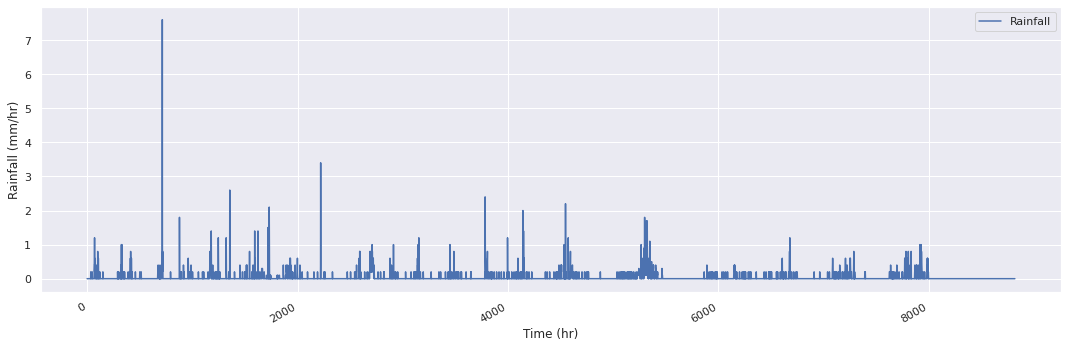

In [12]:
file = '/work/armitagj/runs/caesar-explore/pommeroye/ener440/{}/input_data/rainfall_max1hr_365days.txt'.format(name)
rain = pd.read_csv(file, sep=' ', index_col=False, names=['Rainfall'])
sns.set(rc={'figure.figsize':(15, 5)})
plt.figure()
cols_plot = ['Rainfall']
cols_label = ['Rainfall (mm/hr)']
axes = rain[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time (hr)')
plt.tight_layout()
plt.show()

/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


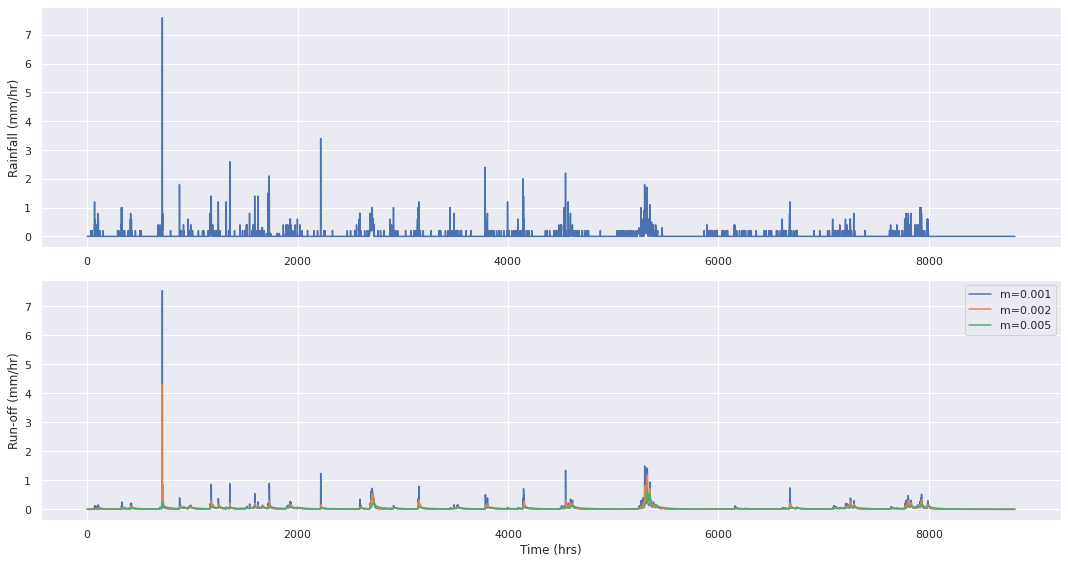

In [20]:
m_ = [0.001, 0.002, 0.005]
dt = 3600
r = np.empty(len(rain.Rainfall))
j = np.empty(len(rain.Rainfall))
rainfall = rain.Rainfall.values / 1000 / 3600
j0 = 0.000000001
plt.figure(figsize=[15,8])
plt.subplot(211)
plt.plot(rain['Rainfall'])
plt.ylabel('Rainfall (mm/hr)')

plt.subplot(212)
for m in m_ :
    for i, p in enumerate(rainfall):
        if i == 0:
            j[i] = j0
            r[i] = m / dt * np.log(1 + (j[i] * dt) / m)
        elif p == 0:
            """
            2832     {
            2833       j[n] = jo[n] / (1 + ((jo[n] * flow_timestep) / M));
            2834 
            2835       new_j_mean[n] = M / flow_timestep *
            2836           std::log(1 + ((jo[n] * flow_timestep) / M));
            2837     }
            """
            j[i] = j[i-1]/(1 + j[i-1] * dt / m)
            r[i] = m / dt * np.log(1 + j[i] * dt / m)
        else:
            """
            2841       j[n] = local_rain_fall_rate / (((local_rain_fall_rate - jo[n]) / jo[n])
            2842           * std::exp((0 - local_rain_fall_rate) * flow_timestep / M) + 1);
            2843 
            2844       new_j_mean[n] = (M / flow_timestep)
            2845           * std::log(((local_rain_fall_rate - jo[n]) + jo[n] *
            2846                       std::exp((local_rain_fall_rate * flow_timestep) / M))
            2847                      / local_rain_fall_rate);
            """
            j[i] = p / (((p - j[i-1]) / j[i-1]) * np.exp((0. - p) * dt / m) + 1)
            r[i] = m / dt * np.log(((p - j[i]) + j[i] * np.exp(p * dt / m)) / p)
    plt.plot(r * 3600 * 1000)
plt.xlabel('Time (hrs)')
plt.ylabel('Run-off (mm/hr)')
plt.legend(['m=0.001', 'm=0.002', 'm=0.005'])
plt.tight_layout()
plt.show()

/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/work/armitagj/miniconda3/envs/caesarpy/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


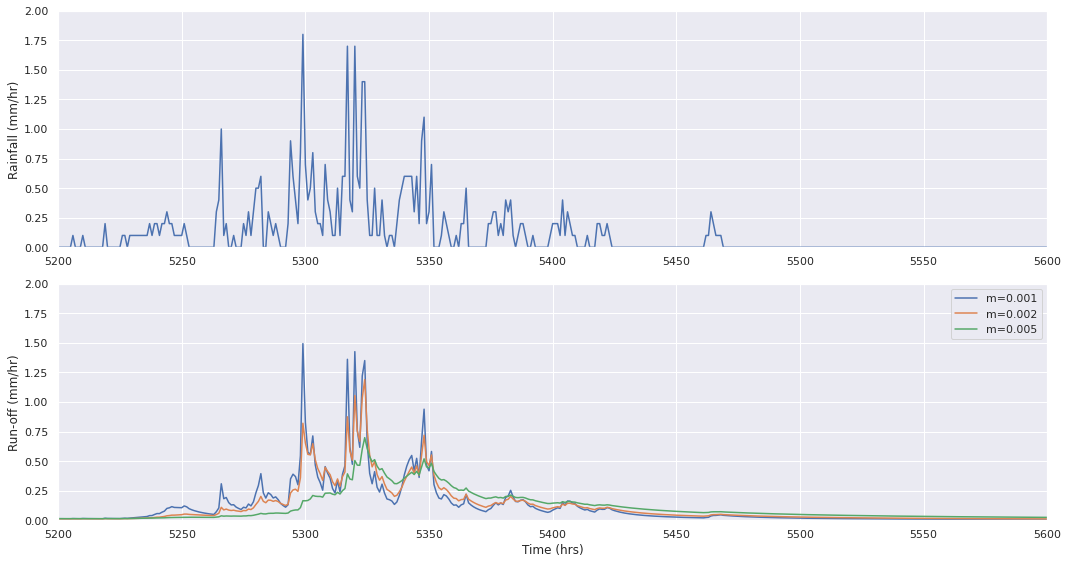

In [26]:
m_ = [0.001, 0.002, 0.005]
dt = 3600
r = np.empty(len(rain.Rainfall))
j = np.empty(len(rain.Rainfall))
rainfall = rain.Rainfall.values / 1000 / 3600
j0 = 0.000000001
plt.figure(figsize=[15,8])
plt.subplot(211)
plt.plot(rain['Rainfall'])
plt.ylabel('Rainfall (mm/hr)')
plt.xlim(5200, 5600)
plt.ylim(0, 2)

plt.subplot(212)
for m in m_ :
    for i, p in enumerate(rainfall):
        if i == 0:
            j[i] = j0
            r[i] = m / dt * np.log(1 + (j[i] * dt) / m)
        elif p == 0:
            """
            2832     {
            2833       j[n] = jo[n] / (1 + ((jo[n] * flow_timestep) / M));
            2834 
            2835       new_j_mean[n] = M / flow_timestep *
            2836           std::log(1 + ((jo[n] * flow_timestep) / M));
            2837     }
            """
            j[i] = j[i-1]/(1 + j[i-1] * dt / m)
            r[i] = m / dt * np.log(1 + j[i] * dt / m)
        else:
            """
            2841       j[n] = local_rain_fall_rate / (((local_rain_fall_rate - jo[n]) / jo[n])
            2842           * std::exp((0 - local_rain_fall_rate) * flow_timestep / M) + 1);
            2843 
            2844       new_j_mean[n] = (M / flow_timestep)
            2845           * std::log(((local_rain_fall_rate - jo[n]) + jo[n] *
            2846                       std::exp((local_rain_fall_rate * flow_timestep) / M))
            2847                      / local_rain_fall_rate);
            """
            j[i] = p / (((p - j[i-1]) / j[i-1]) * np.exp((0. - p) * dt / m) + 1)
            r[i] = m / dt * np.log(((p - j[i]) + j[i] * np.exp(p * dt / m)) / p)
    plt.plot(r * 3600 * 1000)
plt.xlabel('Time (hrs)')
plt.ylabel('Run-off (mm/hr)')
plt.legend(['m=0.001', 'm=0.002', 'm=0.005'])
plt.xlim(5200, 5600)
plt.ylim(0, 2)
plt.savefig('plots/topmodel.png', dpi=300)
plt.tight_layout()

In [ ]:
# j_mean[n] = old_j_mean[n] + (( (new_j_mean[n] - old_j_mean[n]) / 2) * (2 - time));